In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Result:
  def __init__(self):
    self.min_cost = float('inf')

class findPath:

  def brute_force_dfs(self, spot, n, graph, visited, cost, result):
    if len(visited) == n:
      result.min_cost = min(result.min_cost, cost)
      return

    for next_spot in graph[spot]:
      if next_spot in visited:
        continue
    visited.add(next_spot)
    self.brute_force_dfs(next_spot, n, graph, visited, cost + graph[spot][next_spot], result)
    visited.remove(next_spot)

  def minCost(n, mcd, list_of_intersection):
    graph = self.construct_graph(list_of_intersection)
    result = Result()
    n = len(list_of_intersection)
    self.brute_force_dfs(mcd, n, graph, set(mcd), 0, result)

  # def prunning_dfs(self, spot, n, graph, visited, cost, result)

  # def dp_findPath(self, graph, list_of_intersection, mcd)


In [3]:
class Node:
    def __init__(self):
        self.isVisited = False
        self.hasMCD = False
        self.neighbors = list()
        self.MCDRegion = (-1,-1)
        self.color = [255,255,255]

    def __repr__(self):
        return '(McD: {} isVisited: {} regionalMcD: {})'.format(self.hasMCD, self.isVisited, self.MCDRegion)

In [4]:
class Grid:
  def __init__(self, streets=228, aves=13):
    self.streets = streets
    self.aves = aves
    self.grid = [[Node() for y in range(aves)] for x in range(streets)]

  def draw_map(self):
    r = ''
    for x in range(self.streets):
      r += f'{x}: '
      for y in range(self.aves):
        if self.grid[x][y].hasMCD:
            r += f'[{self.grid[x][y].hasMCD}] '
        else:
            r += f'[{self.grid[x][y].MCDRegion}] '
      r += '\n'
    return r
  
  def __repr__(self):
    return self.draw_map()

In [5]:
import random
def rand_color():
    return [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]

In [6]:
McD_loc = "McDonald_loc.txt"

In [7]:
with open(McD_loc) as f:
    mcd_loc_data = []
    for line in f:
        s = line.split(",")
        s[0] = int(s[0])
        s[1] = int(s[1])
        s.append(rand_color())
        mcd_loc_data.append(s)

In [8]:
MD_loc_data = pd.DataFrame(mcd_loc_data,columns=['SN_Street', 'EW_Avenue', 'Inter_Names', 'Color'])
MD_loc_data.head()

,SN_Street,EW_Avenue,Inter_Names,Color
0,11,5,MaidenLn+Broadway\n,"[251, 229, 80]"
1,19,6,Chambers+Greenwich\n,"[163, 221, 250]"
2,28,4,Canel+Lafayette\n,"[112, 24, 8]"
3,32,1,Williamsburg+Essex\n,"[115, 77, 54]"
4,35,7,Houston+Varick\n,"[228, 98, 108]"


Description of features:
'SN_Street': We assign street numbers from 1 to 228 from south to north of Manhattan
'EW_Avenue': We assign avenue numbers from 1 to 13 from east to north of Manhattan
'Inter_Names': The name of two streets that have a McDonald's in their intersection

In [9]:
map = Grid()

In [10]:
print(map.grid[0][0])

(McD: False isVisited: False regionalMcD: (-1, -1))


In [11]:
color_mapping = {}

In [12]:
for index, row in MD_loc_data.iterrows():
    st, ave = int(row['SN_Street']) - 1, int(row['EW_Avenue']) - 1
    map.grid[st][ave].hasMCD = True
    color_mapping[(st, ave)] = row['Color']

In [13]:
def calc_euclidean(pos1x, pos1y, pos2x, pos2y):
    return math.sqrt((pos2x - pos1x)**2 + (pos2y - pos1y)**2)

def calc_manhattan(pos1x, pos1y, pos2x, pos2y):
    return abs(pos2x - pos1x) + abs(pos2y - pos1y)

In [14]:
for i in range(len(map.grid)):
    for j in range(len(map.grid[0])):
        min_dis = float('inf')
        for index, row in MD_loc_data.iterrows():
            st, ave = int(row['SN_Street']) - 1, int(row['EW_Avenue']) - 1
            dis = calc_manhattan(i, j, st, ave)
            if dis < min_dis:
                min_dis = dis
                map.grid[i][j].MCDRegion = (st, ave)
                if map.grid[i][j].hasMCD:
                    map.grid[i][j].color = [0, 0, 0]
                else:
                    map.grid[i][j].color = color_mapping[(st, ave)]

In [15]:
map.grid[0][0].color

[251, 229, 80]

In [16]:
from PIL import Image

def make_colors(map, scale=8):
    data = np.zeros((map.streets * scale, map.aves * scale, 3), dtype=np.uint8)
    for i in range(map.streets):
        for j in range(map.aves):
            for k in range(scale):
                for l in range (scale):
                    data[scale*i + k, scale*j + l] = map.grid[i][j].color

    return Image.fromarray(data).transpose(method=Image.ROTATE_180)

In [17]:
c = make_colors(map)

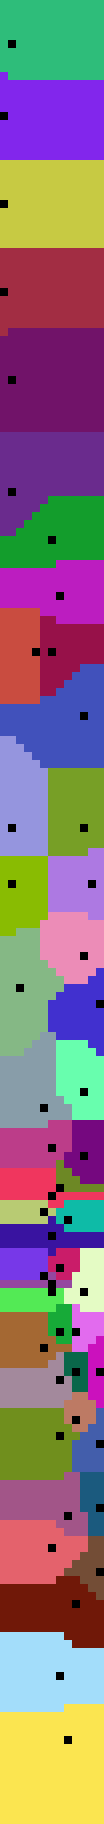

In [18]:
display(c) #jupyter command

In [19]:
c.save('manhattanmcd.png', format=None)

In [20]:
def assign_points(map, prob=0.05):
    locations = []
    for i in range(map.streets):
        for j in range(map.aves):
            if random.random() <= prob:
                locations.append((i, j))
    return locations

In [21]:
delivery_loc = assign_points(map)

In [22]:
#separate locations by McDRegion buckets
def regionize(locations, map):
    regionpoints = {}
    for point in locations:
        i, j = point[0], point[1]
        region = map.grid[i][j].MCDRegion
        if region not in regionpoints:
            regionpoints[region] = []
            regionpoints[region].append(region)
            regionpoints[region].append(point)
        else:
            regionpoints[region].append(point)
    return regionpoints

In [23]:
loc = regionize(delivery_loc, map)

In [24]:
loc

{(10, 4): [(10, 4),
  (1, 11),
  (3, 10),
  (4, 12),
  (5, 0),
  (7, 9),
  (9, 10),
  (10, 1),
  (10, 5),
  (10, 12),
  (11, 8),
  (12, 12),
  (13, 5),
  (13, 11)],
 (18, 5): [(18, 5),
  (14, 5),
  (15, 1),
  (16, 6),
  (18, 2),
  (21, 9),
  (22, 6),
  (22, 9)],
 (27, 3): [(27, 3), (23, 1), (24, 1), (26, 1), (26, 9), (28, 9), (28, 12)],
 (31, 0): [(31, 0), (31, 1), (31, 3)],
 (34, 6): [(34, 6), (31, 8), (33, 8), (34, 7), (34, 11), (35, 3), (35, 8)],
 (38, 4): [(38, 4), (36, 3), (37, 2), (38, 3), (40, 8), (40, 10), (42, 9)],
 (48, 5): [(48, 5), (43, 12), (46, 7), (47, 4), (47, 10), (48, 12), (49, 4)],
 (50, 3): [(50, 3), (52, 3)],
 (55, 5): [(55, 5), (53, 12), (54, 6)],
 (56, 0): [(56, 0), (55, 1), (57, 0)],
 (56, 3): [(56, 3), (57, 3), (58, 4)],
 (59, 7): [(59, 7), (57, 11), (58, 7), (58, 10)],
 (66, 2): [(66, 2), (64, 0), (65, 0)],
 (66, 6): [(66, 6), (64, 10)],
 (68, 7): [(68, 7), (70, 10)],
 (73, 6): [(73, 6), (73, 2), (73, 12)],
 (76, 7): [(76, 7), (75, 9)],
 (79, 5): [(79, 5), (79

In [25]:
def calc_manhattan(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

In [26]:
pip install landscapes

Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install git+https://github.com/nathanrooy/simulated-annealing

  Cloning https://github.com/nathanrooy/simulated-annealing to c:\users\nahte\appdata\local\temp\pip-req-build-daedgoe5
  Resolved https://github.com/nathanrooy/simulated-annealing to commit 42eb34e761b76692882a3905ec2be48e19e8133e
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none -q https://github.com/nathanrooy/simulated-annealing 'C:\Users\nahte\AppData\Local\Temp\pip-req-build-daedgoe5'


In [28]:
import time
runtimes = {}

## Simulated Annealing Implementation

In [29]:
from simulated_annealing import sa
from landscapes.single_objective import tsp

import pandas as pd
# import osmnx as ox
import networkx as nx
import math
import random

In [30]:
tsp_manhattan = tsp(dist_func=calc_manhattan, close_loop=True).dist

In [31]:
tsp_manhattan(delivery_loc)

1152

In [32]:
# cooling_schedule=['linear', 'quadratic', 'exponential', 'logarithmic']
# alpha = None, int(64)
runtimes[sa.__name__] = 0
sa_opt_results = []
for key in loc:
    loc_list = loc[key]
    ts = time.time()
    sa_opt_results.append(sa.minimize(tsp_manhattan, delivery_loc, opt_mode='combinatorial', cooling_schedule = 'quadratic', step_max=1000, t_max=100, t_min=0))
    te = time.time()
    print(f'func: {sa.__name__} took: {te-ts} sec')
    runtimes[sa.__name__] += te - ts

func: simulated_annealing.sa took: 0.06773924827575684 sec
func: simulated_annealing.sa took: 0.047738075256347656 sec
func: simulated_annealing.sa took: 0.04760122299194336 sec
func: simulated_annealing.sa took: 0.04697775840759277 sec
func: simulated_annealing.sa took: 0.042842864990234375 sec
func: simulated_annealing.sa took: 0.020383119583129883 sec
func: simulated_annealing.sa took: 0.04710650444030762 sec
func: simulated_annealing.sa took: 0.047396183013916016 sec
func: simulated_annealing.sa took: 0.04696822166442871 sec
func: simulated_annealing.sa took: 0.06296110153198242 sec
func: simulated_annealing.sa took: 0.0313267707824707 sec
func: simulated_annealing.sa took: 0.031249523162841797 sec
func: simulated_annealing.sa took: 0.03387165069580078 sec
func: simulated_annealing.sa took: 0.03133416175842285 sec
func: simulated_annealing.sa took: 0.047926902770996094 sec
func: simulated_annealing.sa took: 0.04828476905822754 sec
func: simulated_annealing.sa took: 0.04881930351257

In [33]:
sa_opt_results[0].results()

+------------------------ RESULTS -------------------------+

      opt.mode: combinatorial
cooling sched.: quadratic additive cooling


  initial temp: 100
    final temp: 0.000100
     max steps: 1000
    final step: 1000

  final energy: 1152.000000

+-------------------------- END ---------------------------+


In [34]:
sa_opt_results[0].best_energy

1152

In [35]:
annealing_paths = []
sa_total = 0
for region in sa_opt_results:
    annealing_paths.append(region.best_state)
    sa_total += region.best_energy

In [36]:
annealing_paths

[[(1, 11),
  (3, 10),
  (4, 12),
  (5, 0),
  (7, 9),
  (9, 10),
  (10, 1),
  (10, 5),
  (10, 12),
  (11, 8),
  (12, 12),
  (13, 5),
  (13, 11),
  (14, 5),
  (15, 1),
  (16, 6),
  (18, 2),
  (21, 9),
  (22, 6),
  (22, 9),
  (23, 1),
  (24, 1),
  (26, 1),
  (26, 9),
  (28, 9),
  (28, 12),
  (31, 1),
  (31, 3),
  (31, 8),
  (33, 8),
  (34, 7),
  (34, 11),
  (35, 3),
  (35, 8),
  (36, 3),
  (37, 2),
  (38, 3),
  (40, 8),
  (40, 10),
  (42, 9),
  (43, 12),
  (46, 7),
  (47, 4),
  (47, 10),
  (48, 12),
  (49, 4),
  (52, 3),
  (53, 12),
  (54, 6),
  (55, 1),
  (57, 0),
  (57, 3),
  (57, 11),
  (58, 4),
  (58, 7),
  (58, 10),
  (64, 0),
  (64, 10),
  (65, 0),
  (70, 10),
  (73, 2),
  (73, 12),
  (75, 9),
  (79, 2),
  (80, 10),
  (81, 11),
  (82, 10),
  (83, 1),
  (84, 1),
  (90, 5),
  (96, 2),
  (98, 1),
  (98, 4),
  (101, 1),
  (101, 4),
  (101, 6),
  (102, 2),
  (103, 12),
  (105, 2),
  (115, 7),
  (120, 8),
  (121, 10),
  (121, 12),
  (122, 2),
  (124, 6),
  (124, 8),
  (127, 6),
  (128, 2)

In [37]:
sa_total

46080

### State-compression Dynamic Programming to computer the min-cost (shortest path start from the first location but do not return to the initial location)

In [38]:
def dp(n, locations):
	graph = construct_graph(locations, n)
	# for i in range(1, n + 1):
	# 	print(graph[i][1])

	state_size = 1 << n
	f = [
		[float('inf')] * (n + 1)
		for _ in range(state_size)
	]
	f[1][1] = 0
	for state in range(state_size):
		for i in range(2, n + 1):
			if state & (1 << (i - 1)) == 0:
				continue

			prev_state = state ^ (1 << (i - 1))
			for j in range(1, n + 1):
				if prev_state & (1 << (j - 1)) == 0:
					continue

				f[state][i] = min(f[state][i], f[prev_state][j] + graph[j][i])

	return min(f[state_size - 1])


def construct_graph(locations, n):
	graph = {
		i: {j: float('inf') for j in range(1, n + 1)}
		for i in range(1, n + 1)
	}

	for i in range(1, n + 1):
		for j in range(1, n + 1):
			graph[i][j] = calc_manhattan(locations[i - 1],locations[j - 1])
			graph[j][i] = graph[i][j]
	return graph

In [39]:
runtimes[dp.__name__] = 0
dp_minCost = []
dp_total = 0
for key in loc:
    loc_list = loc[key]
    ts = time.time()
    dp_minCost.append(dp(len(loc_list), loc_list))
    te = time.time()
    dp_total += dp_minCost[-1]
    print('The global min-cost is: ', dp_minCost[-1])
    print(f'func: {dp.__name__} took: {te-ts} sec')
    runtimes[dp.__name__] += te - ts

The global min-cost is:  53
func: dp took: 0.36383914947509766 sec
The global min-cost is:  25
func: dp took: 0.0 sec
The global min-cost is:  22
func: dp took: 0.0 sec
The global min-cost is:  3
func: dp took: 0.0 sec
The global min-cost is:  20
func: dp took: 0.01566457748413086 sec
The global min-cost is:  19
func: dp took: 0.0 sec
The global min-cost is:  20
func: dp took: 0.0 sec
The global min-cost is:  2
func: dp took: 0.0 sec
The global min-cost is:  9
func: dp took: 0.0 sec
The global min-cost is:  4
func: dp took: 0.0 sec
The global min-cost is:  3
func: dp took: 0.0 sec
The global min-cost is:  6
func: dp took: 0.0 sec
The global min-cost is:  4
func: dp took: 0.0 sec
The global min-cost is:  6
func: dp took: 0.0 sec
The global min-cost is:  5
func: dp took: 0.0 sec
The global min-cost is:  14
func: dp took: 0.0 sec
The global min-cost is:  3
func: dp took: 0.0 sec
The global min-cost is:  3
func: dp took: 0.0 sec
The global min-cost is:  8
func: dp took: 0.0 sec
The global 

## Held-Karp Implementation

In [40]:
import itertools

def construct_dists(locations, n):
	dists = [[0] * n for i in range(n)]

	for i in range(n):
		for j in range(n):
			dists[i][j] = calc_manhattan(locations[i],locations[j])
			# graph[j][i] = graph[i][j]
	return dists

def held_karp(n, locations):

    dists = construct_dists(locations, n)
    # print(dists)

    # Maps each subset of the nodes to the cost to reach that subset, as well
    # as what node it passed before reaching this subset.
    # Node subsets are represented as set bits.
    C = {}

    # Set transition cost from initial state
    for k in range(1, n):
        C[(1 << k, k)] = (dists[0][k], 0)

    # Iterate subsets of increasing length and store intermediate results
    # in classic dynamic programming manner
    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            # Set bits for all nodes in this subset
            bits = 0
            for bit in subset:
                bits |= 1 << bit

            # Find the lowest cost to get to this subset
            for k in subset:
                prev = bits & ~(1 << k)

                res = []
                for m in subset:
                    if m == 0 or m == k:
                        continue
                    res.append((C[(prev, m)][0] + dists[m][k], m))
                C[(bits, k)] = min(res)

    # We're interested in all bits but the least significant (the start state)
    bits = (2**n - 1) - 1

    # Calculate optimal cost
    res = []
    for k in range(1, n):
        res.append((C[(bits, k)][0] + dists[k][0], k))
    opt, parent = min(res)

    # Backtrack to find full path
    path = []
    for i in range(n - 1):
        path.append(parent)
        new_bits = bits & ~(1 << parent)
        _, parent = C[(bits, parent)]
        bits = new_bits

    # Add implicit start state
    path.append(0)

    return opt, list(reversed(path))

In [41]:
hk_results = []
runtimes[held_karp.__name__] = 0
for key in loc:
    loc_list = loc[key]
    ts = time.time()
    hk_results.append(held_karp(len(loc_list), loc_list))
    te = time.time()
    print(f'func: {held_karp.__name__} took: {te-ts} sec')
    runtimes[held_karp.__name__] += te - ts

func: held_karp took: 0.12559890747070312 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.

## Runtime Analysis

<BarContainer object of 3 artists>

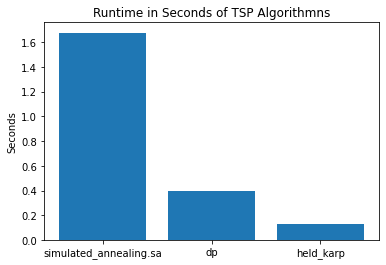

In [42]:
k, v = runtimes.keys(), runtimes.values()
plt.title('Runtime in Seconds of TSP Algorithmns')
plt.ylabel('Seconds')
plt.bar(k, v)